# Part 3.1 – Individual Athlete Visualization (Pair Work)

**Contributor:** Jonathan Jafari  
**Athletes:** PLAYER_680, PLAYER_965  
**Metric:** Jump Height (m)  
**Figure file (screenshot requirement):** `screenshots/part3_player680_line_plot.png`

This notebook connects to the shared MySQL database, filters the Vert system data for two specific basketball athletes, and visualizes **Jump Height(m)** over time. The first figure (PLAYER_680) is saved as a PNG for the assignment screenshot; the second figure (PLAYER_965) is rendered in the notebook.

In [28]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd


load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE} LIMIT 50000"), engine)
df.head()


,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,1,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Braking Force(N),1546.3816,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54
1,2,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Braking Power(W),-1099.2175,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54
2,3,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Braking Velocity(m/s),-0.7630,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54
3,4,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Landing Force(N),1251.3600,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54
4,5,PLAYER_1175,2018-10-15 19:27:41,hawkins,Avg. Propulsive Force(N),1887.0421,Team: Stony Brook,None,None,None,hawkins,2025-10-21 16:46:54


In [29]:
# List most common metrics to help select one
metric_counts = df["metric"].value_counts().head(40)
metric_counts


metric
System Weight(N)                           687
Avg. Landing Force(N)                      678
Relative Peak Landing Force(%)             677
Peak Landing Force(N)                      677
L|R Avg. Landing Force(%)                  676
L|R Peak Landing Force(%)                  676
Landing Stiffness(N/m)                     675
Avg. Propulsive Force(N)                   671
Avg. Propulsive Power(W)                   671
Avg. Propulsive Velocity(m/s)              671
Avg. Relative Propulsive Force(%)          671
Positive Net Impulse(N.s)                  671
Jump Height(m)                             671
Takeoff Velocity(m/s)                      670
Propulsive Phase(s)                        670
Peak Velocity(m/s)                         670
Peak Propulsive Power(W)                   670
Peak Propulsive Force(N)                   670
Propulsive Net Impulse(N.s)                670
L|R Propulsive Impulse Index(%)            669
L|R Peak Propulsive Force(%)               669
L|R Av

In [30]:
# Replace with the chosen metric name from metric_counts output
metric_of_interest = "Jump Height(m)"

players_with_metric = (
    df[df["metric"] == metric_of_interest]["playername"]
    .value_counts()
    .head(20)
)

players_with_metric


playername
PLAYER_680     22
PLAYER_965     21
PLAYER_893     20
PLAYER_032     19
PLAYER_1208    18
PLAYER_1167    17
PLAYER_664     16
PLAYER_892     16
PLAYER_1204    15
PLAYER_430     14
PLAYER_752     13
PLAYER_643     13
PLAYER_528     12
PLAYER_070     11
PLAYER_753     10
PLAYER_624      9
PLAYER_708      7
PLAYER_185      6
PLAYER_826      6
PLAYER_594      6
Name: count, dtype: int64

In [31]:
player_1 = "PLAYER_680"
player_2 = "PLAYER_965"
metric_of_interest = "Jump Height(m)"


In [32]:
import matplotlib.pyplot as plt

def plot_player_timeline(player_name, filename=None):
    # Filter for one athlete + metric
    subset = df[
        (df["playername"] == player_name) &
        (df["metric"] == metric_of_interest)
    ].copy()

    subset = subset.sort_values("timestamp")

    # Line plot
    plt.figure(figsize=(12, 5))
    plt.plot(subset["timestamp"], subset["value"], marker='o')
    plt.xlabel("Date")
    plt.ylabel(metric_of_interest)
    plt.title(f"{metric_of_interest} Over Time for {player_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300)

    plt.show()



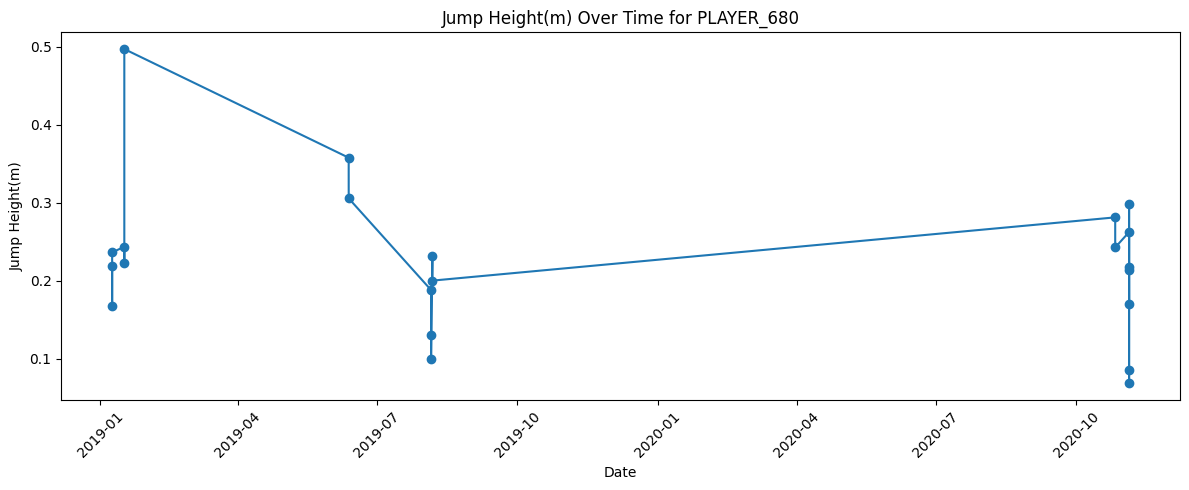

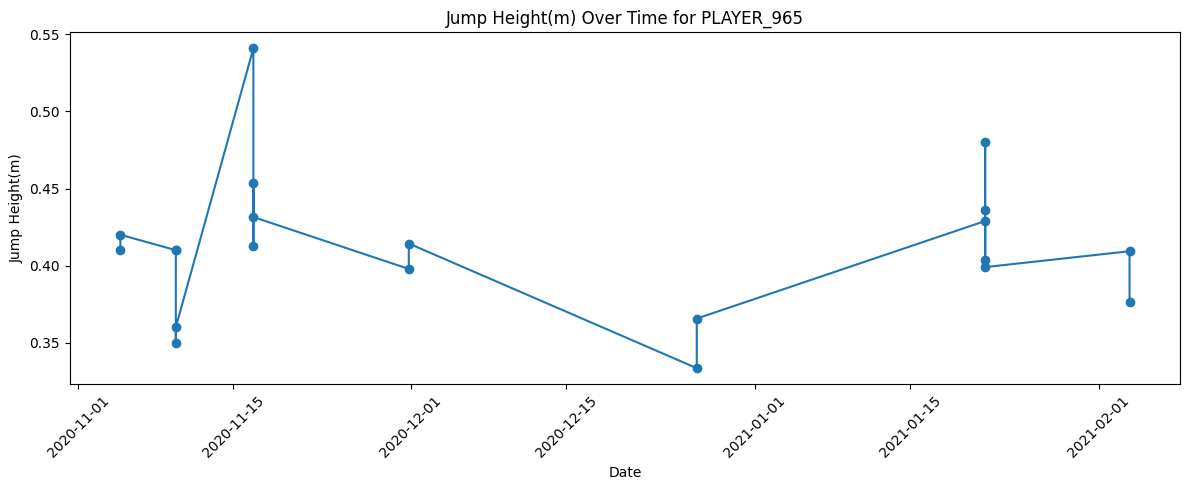

In [35]:
# PLAYER_680 – main screenshot figure
plot_player_timeline(
    player_name=player_1,
    filename="screenshots/jonathan_part3_player680_line_plot.png"
)

# PLAYER_965 – second athlete screenshot
plot_player_timeline(
    player_name=player_2,
    filename="screenshots/jonathan_part3_player965_line_plot.png"
)


# Xiao's Version 3.1 Individual Athlete Timeline (Pair Work)

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
pd.set_option("display.max_rows", None)

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE}"), engine)
df.head()


selected_metrics = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]


Database connection established successfully.


In [ ]:
# filter teams based on coverage of selected metrics
metrics_sql = ", ".join([f"'{m}'" for m in SELECTED_METRICS])

query_team_coverage = f"""
SELECT 
    team,
    COUNT(DISTINCT metric) AS num_metrics_found
FROM {DB_TABLE}
WHERE metric IN ({metrics_sql})
GROUP BY team
ORDER BY num_metrics_found DESC;
"""

team_coverage = pd.read_sql(text(query_team_coverage), engine)
team_coverage

,team,num_metrics_found
0,Team: Old Football,5
1,Team: Stony Brook Men's Soccer,5
2,"Team: Stony Brook Men's Basketball , Team: Men...",5
3,Team: Stony Brook Men's Basketball,5
4,"Team: Stony Brook Football, Team: Stony Brook",5
5,Team: Stony Brook Football,5
6,Team: Stony Brook Baseball,5
7,Team: Stony Brook,5
8,Team: SBU WLAX,5
9,Team: Stony Brook Men's T&F,5


In [ ]:
# Filter players who have all 5 selected metrics from the chosen team
chosen_team = "Team: Stony Brook Men's Basketball".replace("'","''")
query_playersallmetrics = f"""
SELECT
    playername,
    COUNT(DISTINCT metric) AS num_metrics,team
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
  AND metric IN ({metrics_sql})
GROUP BY playername
HAVING num_metrics = {len(selected_metrics)}
ORDER BY team
"""

df_playersallmetrics = pd.read_sql(text(query_playersallmetrics), engine)
df_playersallmetrics

,playername,num_metrics,team
0,PLAYER_002,5,Team: Stony Brook Men's Basketball
1,PLAYER_074,5,Team: Stony Brook Men's Basketball
2,PLAYER_1036,5,Team: Stony Brook Men's Basketball
3,PLAYER_1050,5,Team: Stony Brook Men's Basketball
4,PLAYER_1188,5,Team: Stony Brook Men's Basketball
5,PLAYER_1282,5,Team: Stony Brook Men's Basketball
6,PLAYER_1283,5,Team: Stony Brook Men's Basketball
7,PLAYER_1285,5,Team: Stony Brook Men's Basketball
8,PLAYER_243,5,Team: Stony Brook Men's Basketball
9,PLAYER_324,5,Team: Stony Brook Men's Basketball


In [ ]:
# PLAYER_999 and PLAYER_404 has been chosen for our metrics
# create my main database and clean up types on data for plotting function
player_list = ["PLAYER_999", "PLAYER_404"]
player_sql = ", ".join([f"'{p.replace("'", "''")}'" for p in player_list])

query_team_metrics = f"""
SELECT * 
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
AND playername IN ({player_sql})
AND metric IN ({metrics_sql});
"""
df_team = pd.read_sql(text(query_team_metrics),engine)

df_team["timestamp"] = pd.to_datetime(df_team['timestamp'])
df_team["value"] = pd.to_numeric(df_team['value'], errors ='coerce')

print(df_team.shape)
df_team.head()

(620, 12)


,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,5868614,PLAYER_404,2025-06-23 14:19:39,hawkins,Jump Height(m),0.4595,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
1,5868643,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Propulsive Force(N),2355.0000,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
2,5868649,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Velocity(m/s),3.0826,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
3,5868653,PLAYER_404,2025-06-23 14:19:39,hawkins,Propulsive Net Impulse(N.s),253.5380,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
4,5868676,PLAYER_404,2025-06-23 14:19:39,hawkins,mRSI,0.6418,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10


In [ ]:
months_back = 12
PLAYER_999 = "PLAYER_999"
PLAYER_404 = "PLAYER_404"

# Plotting function for individual players by selected metrics
def plot_player_metrics(df_team, athlete, selected_metrics, months_back=12):
    df_team = df_team[df_team['playername'] == athlete].copy()
    if df_team.empty:
        print(f"No data found for {athlete}.")
        return pd.DataFrame

    #sort out data chronologically
    df_team = df_team.sort_values("timestamp")

    #restict to last 12 months
    max_date = df_team["timestamp"].max()
    min_date = max_date - pd.DateOffset(months=months_back)
    df_team = df_team[df_team["timestamp"] >= min_date]

    print(f"\n===== Player: {athlete} =====")
    print(f" Data range: {df_team['timestamp'].min()} to {df_team['timestamp'].max()}")
    print(f"Rows: {df_team.shape[0]}")
    summary_rows = []

    for metric in selected_metrics:
        metric_data = df_team[df_team['metric'] ==metric].copy()
        if metric_data.empty:
            print(f" No data for metric: {metric}")
            continue

        #Plotting
        plt.figure(figsize=(10,4))
        plt.plot(metric_data['timestamp'], metric_data['value'], marker='o')
        plt.title(f"{metric} over time - {athlete}")
        plt.xlabel("Date")
        plt.ylabel(metric)
        plt.xticks(rotations=45)
        plt.tight_layout()
        plt.show()

        #Best and worse performances
        best_perf = metric_data['value'].idxmax()
        worst_perf = metric_data['value'].idxmin()

        best_value = metric_data.loc[best_perf, "value"]
        best_date = metric_data.loc[best_perf, "timestamp"]

        worst_value = metric_data.loc[worst_perf, "value"]
        worst_date = metric_data.loc[worst_perf, "timestamp"]

        #linear trend
        metric_data = metric_data(subset=["timestamp", "value"]).copy()
        metric_data["ts_num"] = metric_data['timestamp'].map(pd.Timestamp.toodinal)

        if len(metric_data) >1:
            slope, intercept, r, p, stderr = linregress(metric_data['ts_num'], metric_data['value'])
        else:
            slope, intercept, r, p, stderr = (0,0,0,1,0)

        summary_rows.append({
            metric,
            best_value, best_date,
            worst_value, worst_date,
            slope, r, p
        })

        summary_df = pd.DataFrame(
            summary_rows,
            columns=[
                "Metric",
                "Best Value", "Best Date",
                "Worst Value", "Worst Date",
                "Trend Slope", "R-value", "P-value"
            ]
        )
        
    return summary_df

In [ ]:
# run for PLAYER_999
summary_PLAYER_999 = plot_player_metrics(
    df_team,
    PLAYER_999,
    selected_metrics,
    months_back=12
)  

summary_PLAYER_999

In [ ]:
#run for PLAYER_404
summary_PLAYER_404 = plot_player_metrics(
    df_team,
    PLAYER_404,
    selected_metrics,
    months_back=12
)

summary_PLAYER_404

# 3.1 Individual Athlete Timeline (Pair Work)
## Contributor: Anthony Mapuyan 

In [1]:
# Establish database connection and import libraries
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE", "research_experiment_refractor_test")

connection_string = (   
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

Matplotlib is building the font cache; this may take a moment.


Database connection established successfully.


In [ ]:
SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]
